In [17]:
# Import required libraries
import pandas as pd
import numpy as np
df = pd.read_csv("train.csv")

In [18]:
df.shape

(1460, 81)

In [19]:
df.head(n=5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# (1) Helper Functions for Pipeline

### Function for Removing Rows

In [24]:
# Given a list of indices (rows) to drop, this returns a copy of the original df without those rows
def remove_rows_from_df(df, list_of_rows_to_drop, printDetails = False):
    df_rows_removed = df.drop(df.index[list_of_rows_to_drop])
    if printDetails:
        print(len(list_of_rows_to_drop),"observations (rows) dropped from dataframe")
        print("Dimensions of new dataframe:", df_rows_removed.shape)
    return df_rows_removed

# Example of usage
list_of_rows_to_remove = [57, 57, 72, 101]
df_with_rows_removed = remove_rows_from_df(df, list_of_rows_to_remove, printDetails = True)

4 observations (rows) dropped from dataframe
Dimensions of new dataframe: (1457, 81)


### Function for Removing Outlier Rows

In [27]:
# Input: dataframe, column name, and threshold for determining if observation is outlier in column
# Ouput: a set whose elements are the indices (rows) of the outliers in this data frame
def indices_of_outliers(df, column_name, stdev_threshold, printDetails = False):
    mask_of_outliers = np.abs(df[column_name] - df[column_name].mean()) >= (stdev_threshold*df[column_name].std())
    set_of_indices_of_outliers = set(df.index[mask_of_outliers].tolist())
    if printDetails:
        print("There are",len(set_of_indices_of_outliers),"outliers in",column_name,"and their indices are:")
        print(set_of_indices_of_outliers)
    return set_of_indices_of_outliers

# "Vectorized" version of set_of_outliers and removes all of them from dataframe
# Non-mutatable, i.e. - original dataframe is not modified. Returns a new dataframe without outliers
def remove_rows_with_outliers(df, list_of_column_names, stdev_threshold, printDetails = False):
    set_of_indices_of_all_outliers = set()
    for column_name in list_of_column_names:
        set_of_indices_of_outliers = indices_of_outliers(df, column_name, stdev_threshold, printDetails)
        if printDetails:
            print("")
        set_of_indices_of_all_outliers = set_of_indices_of_all_outliers.union(set_of_indices_of_outliers)
    list_of_indices_to_drop = list(set_of_indices_of_all_outliers)
    if printDetails:
        print("Dropping outliers based on", stdev_threshold, "standard deviation criteria...")
    df_without_outliers = remove_rows_from_df(df, list_of_indices_to_drop, printDetails)
    return df_without_outliers

# Example of usage
list_of_column_names = ["LotFrontage", "OverallQual"]
df_without_outliers = remove_rows_with_outliers(df, list_of_column_names, stdev_threshold = 3, printDetails = True)

There are 12 outliers in LotFrontage and their indices are:
{197, 934, 807, 231, 1127, 1337, 909, 1298, 1107, 313, 1211, 1182}

There are 2 outliers in OverallQual and their indices are:
{533, 375}

Dropping outliers based on 3 standard deviation criteria...
14 observations (rows) dropped from dataframe
Dimensions of new dataframe: (1446, 81)


### Function for finding where MSSubClass conflicts with HouseStyle, i.e. - we don't know how many floors the house has

In [28]:
# Define two auxiliary functions to help us comb through this data
#   to find conflicts between the labels of the columns "MSSubClass" and "HouseStyle"
def HouseStyle_Value_Count_for_MSSubClass(df, MSSubClass_label, description):
    print("")
    print("#"*75)
    print("For MSSubClass =",MSSubClass_label,"(",description,")","\nThe values & frequencies of HouseStyle are:")
    print(df.loc[df["MSSubClass"]==MSSubClass_label,"HouseStyle"].value_counts())
    print("")

def Find_MSSubClass_HouseStyle_Conflict(df, MSSubClass_label, HouseStyle_label):
    rows_with_conflict = (df["MSSubClass"]==MSSubClass_label) & (df["HouseStyle"]==HouseStyle_label)
    if (sum(rows_with_conflict) >= 1):
        print("Grabbing problematic observations where MSSubClass =",MSSubClass_label,"but","HouseStyle =", HouseStyle_label,"...")
    else:
        raise ValueError("No rows matching this criterion!")
    return rows_with_conflict

# Example of usage
# MSSubClass = 20: 1-STORY 1946 & NEWER ALL STYLES
HouseStyle_Value_Count_for_MSSubClass(df, 20, "1-STORY 1946 & NEWER ALL STYLES")
mask_1 = Find_MSSubClass_HouseStyle_Conflict(df, 20, "2Story")
print(sum(mask_1),"observation(s)")

print("")

mask_2 = Find_MSSubClass_HouseStyle_Conflict(df, 20, "SLvl")
print(sum(mask_2),"observation(s)")


###########################################################################
For MSSubClass = 20 ( 1-STORY 1946 & NEWER ALL STYLES ) 
The values & frequencies of HouseStyle are:
1Story    534
2Story      1
SLvl        1
Name: HouseStyle, dtype: int64

Grabbing problematic observations where MSSubClass = 20 but HouseStyle = 2Story ...
1 observation(s)

Grabbing problematic observations where MSSubClass = 20 but HouseStyle = SLvl ...
1 observation(s)


### Function for finding houses that fail the sanity check, i.e. - square footage of basement = 0 but there is a bathroom in the basement, the renovation date is after the sell date, etc.

In [34]:
df.loc[df["YearRemodAdd"] > df["YrSold"], ["YearRemodAdd","YrSold","YearBuilt"]]

# Age of house = YearSold - 0.6*YearRemod - 0.4*YrBuilt
# This would produce a negative age
# Proposed solution: add 1.0 year to every single house's age...then this observation would become positive

,YearRemodAdd,YrSold,YearBuilt
523,2008,2007,2007


In [35]:
# MasVnrArea = 0, but the MasVnrType is "Stone" or "BrkFace"

x = df.loc[df["MasVnrArea"]==0]
x["MasVnrType"].value_counts()

None       859
BrkFace      1
Stone        1
Name: MasVnrType, dtype: int64

### Function for dummifying categorical variables

In [8]:
??????????????

Object `????????????` not found.


In [36]:
df["BsmtQual"].head(n=10)

0    Gd
1    Gd
2    Gd
3    TA
4    Gd
5    Gd
6    Ex
7    Gd
8    TA
9    TA
Name: BsmtQual, dtype: object

In [37]:
df["BsmtQual"].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [38]:
BsmtQual_dict = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1}
df["BsmtQual_numeric"] = [BsmtQual_dict[x] for x in df["BsmtQual"].values]
pd.get_dummies(df, prefix=["BsmtQual"])

KeyError: nan

# (2) Actual Pipeline Using Helper Functions

### Remove outliers for all numeric features (columns)

In [ ]:
list_of_column_names = [???????????]
df_without_outliers = remove_rows_with_outliers(df, list_of_column_names, stdev_threshold = 3, printDetails = False)

### Remove rows where MSSubClass conflicts with HouseStyle.  Just showing this for cases where MSSubClass = 20.  We need to continue searching for all cases, such as MSSubClass = 30, 40, etc...

# Training Linear Regression Model

In [42]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from math import sqrt
from statistics import mean 

In [43]:
list_of_predictors = ["GrLivArea", "LotArea", "OverallQual"]

In [44]:
X = df[list_of_predictors].to_numpy()
y = df["SalePrice"].to_numpy()

In [45]:
n_splits = 5

list_of_exponents = list(range(-2,4))
alpha_vector = np.power(10.0, list_of_exponents)
RMSE_vector = []

for alpha in alpha_vector:
    
    RMSE_per_fold = []
    kf = KFold(n_splits = n_splits, shuffle = True)
    
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lasso_model = linear_model.Lasso(alpha = alpha)
        lasso_model.fit(X_train, y_train)
        y_test_predicted = lasso_model.predict(X_test)
        RMSE = sqrt(mean_squared_error(y_test, y_test_predicted))
        R2 = r2_score(y_test, y_test_predicted)
        #print("R-squared=",R2)
        #print("RMSE =",'{:,.0f}'.format(RMSE))
        #print("")
        #print(lasso_model.coef_)
        RMSE_per_fold.append(RMSE)
    
    RMSE_for_given_alpha = mean(RMSE_per_fold)
    RMSE_vector.append(RMSE_for_given_alpha)
    
    print("For alpha =",alpha)
    print("RMSE = ", '{:,.0f}'.format(RMSE_for_given_alpha))
    print("")

print(alpha_vector)
print(RMSE_vector)


For alpha = 0.01
RMSE =  41,984

For alpha = 0.1
RMSE =  41,661

For alpha = 1.0
RMSE =  41,553

For alpha = 10.0
RMSE =  41,907

For alpha = 100.0
RMSE =  41,944

For alpha = 1000.0
RMSE =  42,186

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
[41984.49342461711, 41661.29833277547, 41552.98527135202, 41907.43538782552, 41943.838462903615, 42186.206718216104]


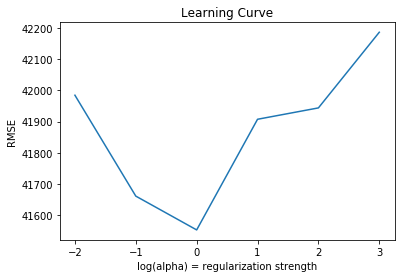

In [47]:
import matplotlib.pyplot as plt

plt.plot(list_of_exponents, RMSE_vector)
plt.title("Learning Curve")
plt.xlabel('log(alpha) = regularization strength')
plt.ylabel('RMSE')
plt.show()